# ランダムなエルミート行列の量子位相推定

Authors: Takumi Kato (Blueqat inc.), Maho Nakata (Riken), Shinya Morino, Seiya Sugo (Quemix inc.), Yuichiro Minato (Blueqat inc.)

[前回](113_pea_ja.ipynb)はZゲートやXゲートの行列の固有値を求めました。今回は、ランダムな2x2エルミート行列の量子位相推定をします。

エルミート行列の固有値を求めることは量子力学において物理量を求めることに相当し、量子化学や量子シミュレーションなどの分野で広く応用が期待されます。

## 固有値の和が0になるエルミート行列の量子位相推定

エルミート行列の固有値を量子位相推定アルゴリズムで求める方法も、大まかな原理は前回と全く同じです。ですが、前回はZ行列やX行列の固有値を求めるために、Controlled-Uゲートとして、Controlled-ZゲートやControlled-Xゲートを用意しましたが、今回、エルミート行列はユニタリ行列になるとは限らないため、Controlled-Uゲートを直接用意することができません。

結論だけを言うと、エルミート行列$\hat H$の固有ベクトルを作るような量子回路を用意して、また、Controlled-UゲートとしてControlled-$e^{2\pi i\hat H}$ゲートを作ります。そうして量子位相推定を行うことで、固有値を求めることができます。

以下の説明は少し難しいので、飛ばしてコードを読んでも構いません。また、ここに書かれていることを理解するには[行列指数関数](https://ja.wikipedia.org/wiki/%E8%A1%8C%E5%88%97%E6%8C%87%E6%95%B0%E9%96%A2%E6%95%B0)についての知識が必要です。

固有値の和が0になるようなエルミート行列$\hat H$を考えます。

$\hat H$が固有値と固有ベクトルの組$\{(\lambda_j, \left|\psi_j\right\rangle)\}$を持つとき、任意の$i$について
$$\hat H\left|\psi_j\right\rangle = \lambda_j \left|\psi_j\right\rangle$$
の関係を満たします。$\hat H$がエルミート行列の場合、$\lambda_j$が必ず実数となることが知られています。

前回は、$\hat H = Z$または$\hat H = X$のようにして、位相キックバックにはControlled-ZゲートやControlled-Xゲートを使いました。ですが、量子ゲートを並べて作れるのはユニタリ行列だけなので、一般のエルミート行列については、全く同じ方法は取ることができません。

そこで、天下り式ですが、ユニタリ行列 $U = e^{2\pi i\hat H}$を使って量子位相推定することを考えてみます。

### $U = e^{2\pi i\hat H}$はユニタリ行列になるか?

$U U^\dagger = I$を示したいので、$U^\dagger$を考えます。
$$\begin{eqnarray}
U^\dagger &=& (e^{2\pi i\hat H})^\dagger\nonumber\\
&=& (\sum_n^\infty \frac{(2\pi i\hat H)^n}{n!})^\dagger\nonumber\\
&=& \sum_n^\infty \frac{((2\pi i\hat H)^n)^\dagger}{n!}\nonumber\\
&=& \sum_n^\infty \frac{(-2\pi i\hat H^\dagger)^n)}{n!}\nonumber\\
&=& \sum_n^\infty \frac{(-2\pi i\hat H)^n)}{n!}\nonumber\\
&=& e^{-2\pi i\hat H}\nonumber
\end{eqnarray}$$
なので、$U U^\dagger = e^{2\pi i\hat H} e^{-2\pi i\hat H}$となります。ここで、$[2\pi i\hat H, -2\pi i\hat H] = 0$なので、$e^{2\pi i\hat H} e^{-2\pi i\hat H} = e^{2\pi i\hat H -2\pi i\hat H} = e^{0\hat H} = I$とできます。すなわち$U U^\dagger = I$なので$U$はユニタリ行列です。

### $U$の固有値と固有ベクトルは何になるか。$\hat H$のそれとの関係は?

$U$の固有ベクトルが$\hat H$の固有ベクトルと同じであることを示し、その固有値を求めます。

ある$\hat H$の固有値と固有ベクトルの組$\lambda_j, \left|\psi_j\right\rangle$を考えます。このとき、
$$\begin{eqnarray}
U \left|\psi_j\right\rangle &=& (\sum_n^\infty \frac{(2\pi i\hat H)^n}{n!})\left|\psi_j\right\rangle\nonumber\\
&=& \sum_n^\infty \frac{(2\pi i)^n \hat H^n \left|\psi_j\right\rangle}{n!}\nonumber\\
&=& \sum_n^\infty \frac{(2\pi i)^n \lambda_j^n \left|\psi_j\right\rangle}{n!}\nonumber\\
&=& \sum_n^\infty \frac{(2\pi i)^n \lambda_j^n}{n!}\left|\psi_j\right\rangle\nonumber\\
&=& \sum_n^\infty \frac{(2\pi i \lambda_j)^n}{n!}\left|\psi_j\right\rangle\nonumber\\
&=& e^{2\pi i \lambda_j}\left|\psi_j\right\rangle\nonumber
\end{eqnarray}$$
なので、$\left|\psi_j\right\rangle$は$U$のひとつの固有ベクトルで、対応する固有値は$e^{2\pi i \lambda_j}$です。

これにより、
$$U\left|\psi_j\right\rangle = e^{2\pi i\lambda_j} \left|\psi_j\right\rangle$$
を量子位相推定することで、$\hat H$の固有値$\lambda_j$を計算できることが分かりました。

## 実装
まず、必要なライブラリをインポートします。また、今回はnumbaバックエンドを使用します。

In [1]:
import math
import cmath
import random
import numpy as np

from blueqat import *
from blueqat.pauli import X, Y, Z, I

BlueqatGlobalSetting.set_default_backend('numba')
pi = math.pi

# Blueqat バージョンチェック
try:
    Circuit().r(0.1)[0].run()
except AttributeError:
    raise ImportError('Blueqat version is old.')

次に、ランダムなエルミート行列を作ります。

位相推定により固有値を求めるには、ターゲットとなるエルミート行列$\hat H$の他に
- 固有ベクトル(またはその近似値)を与える量子回路
- Controlled-$e^{i2\pi \hat H 2^n}$を与える量子回路

が必要です。これらも得られるような形で、エルミート行列を作ります。


エルミート行列は$\hat H = P D P^\dagger$
(ここで、$P$はユニタリ行列、$D$は実対角行列)の形で書き表せます。

このとき、$D$の対角成分が固有値になり、$P$の各列が固有ベクトルとなります。今は、固有値の合計が0になる2x2のエルミート行列を考えるので、$D$の成分は$\pm E$となります(ただし、$\hat H$の固有値のひとつを$E$とおいた)。

そのため、$D$の成分となる$E$をランダムに生成し、また、$P$は、任意のユニタリ行列を与えるゲートであるU3ゲートのパラメータ$\theta, \phi, \lambda$の3つ組をランダムに生成し、

- エルミート行列$\hat H$
- 答え合わせのための固有値$E$
- 固有ベクトルを与える量子回路を作るために必要なU3ゲートのパラメータ$\theta, \phi, \lambda$

を返すような関数を定義します。

In [2]:
def is_hermitian(mat):
    """matがエルミート行列かどうかを判定する"""
    # matの転置共役がmatと等しい場合、matはエルミート行列
    return np.allclose(mat, mat.T.conjugate())

def get_u3_matrix(theta, phi, lam):
    """U3をユニタリ行列の形で得る"""
    # Blueqatのto_unitary()で得られる行列を、numpy形式に変換して作ります。
    u = Circuit().u3(theta, phi, lam)[0].to_unitary()
    return np.array(u.tolist()).astype(np.complex64)

def random_hermitian():
    """ランダムにエルミート行列を作り、
    エルミート行列, 固有値, パラメータ(3つ組)
    を返す。
    """
    # 固有値のひとつをランダムに決める
    eigval = random.random()
    # U3ゲートのパラメータをランダムに決める
    theta = random.random()
    phi = random.random()
    lam = random.random()
    # これらから、エルミート行列を作る
    u3 = get_u3_matrix(theta, phi, lam)
    hermitian = u3 @ np.diag([eigval, -eigval]) @ u3.T.conjugate()
    # エルミート行列であることを確認
    assert is_hermitian(hermitian)
    # エルミート行列, 固有値, パラメータを返す
    return hermitian, eigval, (theta, phi, lam)

エルミート行列を作ってみます。

In [3]:
H, E, (theta, phi, lam) = random_hermitian()
print(H)

[[ 0.38881099+0.j          0.12507926-0.02545279j]
 [ 0.12507926+0.02545279j -0.38881099+0.j        ]]


固有ベクトルは、`theta, phi, lam`とU3ゲートから作ることができます。

In [4]:
vec = Circuit().u3(theta, phi, lam)[0].run()
print(vec)

[0.94269349-0.29391242j 0.15712574-0.01599945j]


これが固有ベクトルであることを確かめるために、`H vec = E vec`が成り立つことを確かめます。

In [5]:
np.allclose(np.dot(H, vec), E * vec)

True

準備ができたので、これから量子位相推定を実装していきます。具体的には、`theta, phi, lam`から量子回路を作って、量子位相推定により`E`を求めます。

In [6]:
def iqft(c, q0, n_qubits):
    """回路のq0〜q0 + n_qubits - 1番目ビットに量子逆フーリエ変換の操作を付け加える"""
    for i in reversed(range(n_qubits)):
        angle = -0.5
        for j in range(i + 1, n_qubits):
            c.cr(angle * pi)[q0 + j, q0 + i]
            angle *= 0.5
        c.h[q0 + i]
    return c


def initial_circuit(theta, phi, lam):
    """初期回路(つまり、固有ベクトルを表す回路)を用意します"""
    return Circuit().u3(theta, phi, lam)[0]


def apply_cu(c, ctrl, theta, phi, lam, eigval, n):
    """Controlled-U^(2^n)を量子回路cに付け加えて返します。
    制御ビットをctrl, 標的ビットを0としています。
    
    ここで、この関数は固有値eigvalを引数にとっていることに気をつけて下さい。
    今回は、固有値を使って(ズルをして)Controlled-U^(2^n)を作ります。
    固有値を使わなくても、鈴木-トロッター展開などにより、近似的に作ることはできますが、
    その場合、精度には十分注意が必要です。
    このようなズルをせず、効率よく高精度に、こういった回路を作ることは、一般には困難です。
    """
    return c.u3(-theta, -lam, -phi)[0].crz(-2 * pi * eigval * (2**n))[ctrl, 0].u3(theta, phi, lam)[0]

def qpe_circuit(eigval, theta, phi, lam, precision):
    """固有値、U3のパラメータ、位相推定の精度(何桁求めるか)から、量子位相推定の回路を作成して返します。"""
    c = initial_circuit(theta, phi, lam)
    c.h[1:1 + precision]
    for i in range(precision):
        apply_cu(c, i + 1, theta, phi, lam, eigval, i)
    iqft(c, 1, precision)
    return c

試しに、量子回路を見てみましょう。

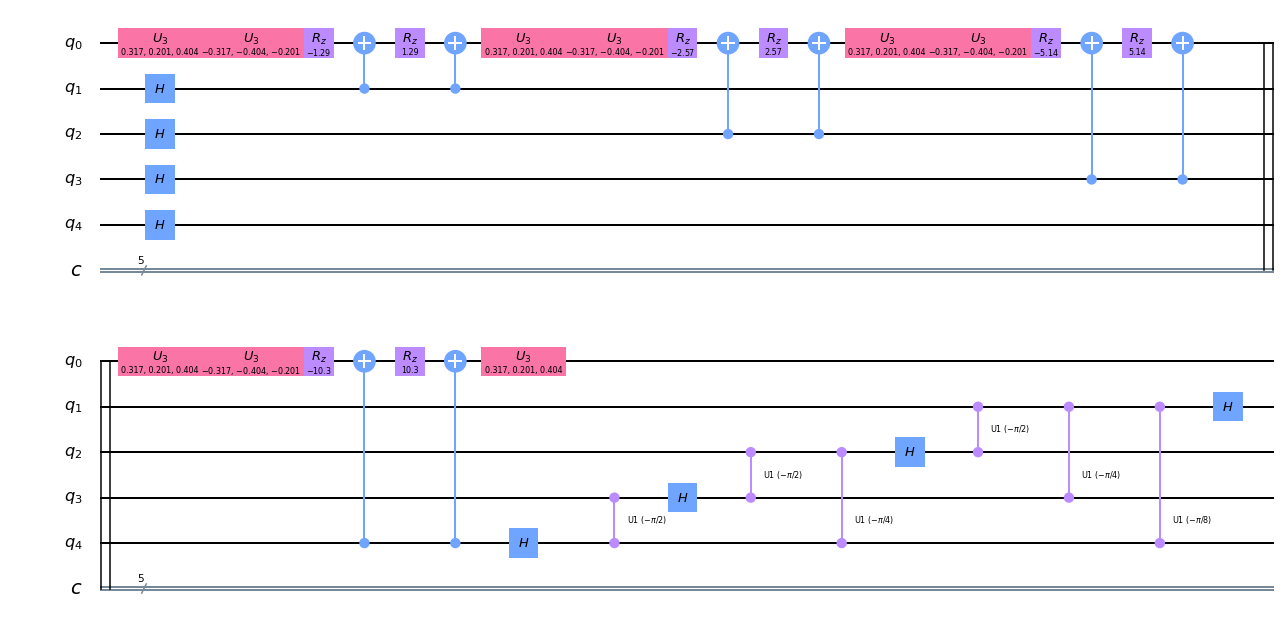

In [7]:
qpe_circuit(E, theta, phi, lam, 4).run_with_ibmq(returns='draw', output='mpl')

続いて、測定結果から固有値を計算する関数を作ります。

In [8]:
def run_qpe(c, shots=1000, max_candidates=5):
    """量子位相推定の回路を実行し、実行結果から固有値の候補を求めます。
    shots: 量子回路をrunする際のショット数, max_candidates: 固有値の候補をいくつ返すか?
    """
    cnt = c.m[1:].run(shots=shots)

    # 測定結果を値に変換する
    def to_value(k):
        k = k[1:] # 測定結果のうち、最初のビットは無関係なので捨てる
        val = 0 # 値
        a = 1.0 
        for ch in k:
            if ch == '1':
                val += a
            a *= 0.5
        if val > 1:
            # 位相がπを越えたら、2π引いて、マイナスで考える
            val = val - 2
        return val

    return [(to_value(k), v) for k, v in cnt.most_common(max_candidates)]

いよいよ、量子位相推定を行い、結果を見ていきます。

In [9]:
print('Eigenvalue (expected):', E) # これが答え。これ(に近い値が出てほしい)
# 精度が小さいときと大きいときの違いを見るため、精度を振って動かしてみる。
for precision in range(3, 16):
    print(precision, 'bit precision:')
    c = qpe_circuit(E, theta, phi, lam, precision)
    result = run_qpe(c, 1000, 3)
    for value, count in result:
        # 1000 shotsのうち、その数が出た回数 得られた固有値 実際の固有値との差分 を表示します。
        print(f'{count:<5}{value:<18}(deviation: {value - E: .3e})')
    print('')

Eigenvalue (expected): 0.4092269088007868
3 bit precision:
619  0.5               (deviation:  9.077e-02)
231  0.25              (deviation: -1.592e-01)
50   0.75              (deviation:  3.408e-01)

4 bit precision:
786  0.375             (deviation: -3.423e-02)
114  0.5               (deviation:  9.077e-02)
30   0.25              (deviation: -1.592e-01)

5 bit precision:
454  0.4375            (deviation:  2.827e-02)
347  0.375             (deviation: -3.423e-02)
47   0.5               (deviation:  9.077e-02)

6 bit precision:
966  0.40625           (deviation: -2.977e-03)
9    0.375             (deviation: -3.423e-02)
6    0.4375            (deviation:  2.827e-02)

7 bit precision:
880  0.40625           (deviation: -2.977e-03)
54   0.421875          (deviation:  1.265e-02)
23   0.390625          (deviation: -1.860e-02)

8 bit precision:
586  0.40625           (deviation: -2.977e-03)
254  0.4140625         (deviation:  4.836e-03)
50   0.3984375         (deviation: -1.079e-02)

9 bi

比較的精度よく求まっていることが分かります。

## 固有値の和が0にならないエルミート行列の量子位相推定
一般には、エルミート行列の固有値は和が0になりません。その場合も基本的には、固有値の和が0の場合と変わらないのですが、Controlled-Uゲートの作り方が少し変わってきます。

$U = e^{2\pi i\hat H}$ の部分に注目します。固有値の和は、行列のトレース(対角和)に相当しましたので、$U$のトレースを考えると、
$$\begin{eqnarray}
\mathrm{tr}(U) &=& \mathrm{tr}\left(\sum_{n=0}^{\infty}\frac{(2\pi i \hat H)^n}{n!}\right)\nonumber\\
&=&\sum_{n=0}^{\infty}\mathrm{tr}\left(\frac{(2\pi i \hat H)^n}{n!}\right)\nonumber\\
&=&\sum_{n=0}^{\infty}\frac{(2\pi i \mathrm{tr}(\hat H))^n}{n!}\nonumber\\
&=&e^{2\pi i \mathrm{tr}(\hat H)}\nonumber\\
\end{eqnarray}$$
となります。このトレース部分は$U$のグローバル位相として現れます。$U$のグローバル位相を考慮に入れたControlled-Uゲートを作ることで、先ほどと同じように量子位相推定ができます。このようなControlled-Uゲートは、制御ビットにRZゲートを余分に入れることで作ることができます。

In [10]:
def random_hermitian2():
    """ランダムにエルミート行列を作り、
    エルミート行列, 固有値(2つ組), パラメータ(3つ組)
    を返す。
    """
    # 固有値をランダムに決める。先程は固有値の範囲を0〜1にしたが、今回は-1〜1にしてみる。
    eigvals = [random.random() * 2 - 1, random.random() * 2 - 1]
    # 固有値を小さい順に並べる(この処理は、望まないならコメントアウトしてもよい)
    eigvals.sort()
    # U3ゲートのパラメータをランダムに決める
    theta = random.random()
    phi = random.random()
    lam = random.random()
    # これらから、エルミート行列を作る
    u3 = get_u3_matrix(theta, phi, lam)
    hermitian = u3 @ np.diag(eigvals) @ u3.T.conjugate()
    # エルミート行列であることを確認
    assert is_hermitian(hermitian)
    # エルミート行列, 固有値, パラメータを返す
    return hermitian, eigvals, (theta, phi, lam)

In [11]:
H, eigvals, (theta, phi, lam) = random_hermitian2()
print(H)

[[-0.09314799+0.00000000e+00j -0.00887058+7.70476954e-03j]
 [-0.00887058-7.70476954e-03j  0.11637164-6.93889390e-18j]]


In [12]:
def apply_cu2(c, ctrl, theta, phi, lam, eigvals, n):
    """apply_cuを改造し、グローバル位相も考慮に入れられるようにした。
    eigvals引数には、固有値の組を入れる。
    """
    bias = sum(eigvals) / 2
    angle = (eigvals[0] - eigvals[1]) / 2
    return c.u3(-theta, -lam, -phi)[0].crz(-2 * pi * angle * (2**n))[ctrl, 0].u3(theta, phi, lam)[0].rz(pi * bias * (2**n))[ctrl]

def qpe_circuit2(eigvals, theta, phi, lam, precision):
    """apply_cu2を使うよう、改造した。"""
    c = initial_circuit(theta, phi, lam)
    c.h[1:1 + precision]
    for i in range(precision):
        apply_cu2(c, i + 1, theta, phi, lam, eigvals, i)
    iqft(c, 1, precision)
    return c

まず、1番目の固有値を求めます。

In [13]:
print('Eigenvalue (expected):', eigvals[0]) # これが答え。これ(に近い値が出てほしい)
# 精度が小さいときと大きいときの違いを見るため、精度を振って動かしてみる。
for precision in range(3, 16):
    print(precision, 'bit precision:')
    c = qpe_circuit2(eigvals, theta, phi, lam, precision)
    result = run_qpe(c, 1000, 3)
    for value, count in result:
        # 1000 shotsのうち、その数が出た回数 得られた固有値 実際の固有値との差分 を表示します。
        print(f'{count:<5}{value:<18}(deviation: {value - eigvals[0]: .3e})')
    print('')

Eigenvalue (expected): -0.09380483021040753
3 bit precision:
640  0                 (deviation:  9.380e-02)
201  -0.25             (deviation: -1.562e-01)
43   -0.5              (deviation: -4.062e-01)

4 bit precision:
825  -0.125            (deviation: -3.120e-02)
94   0                 (deviation:  9.380e-02)
26   -0.25             (deviation: -1.562e-01)

5 bit precision:
422  -0.125            (deviation: -3.120e-02)
407  -0.0625           (deviation:  3.130e-02)
49   -0.1875           (deviation: -9.370e-02)

6 bit precision:
1000 -0.09375          (deviation:  5.483e-05)

7 bit precision:
1000 -0.09375          (deviation:  5.483e-05)

8 bit precision:
999  -0.09375          (deviation:  5.483e-05)
1    -0.0859375        (deviation:  7.867e-03)

9 bit precision:
1000 -0.09375          (deviation:  5.483e-05)

10 bit precision:
996  -0.09375          (deviation:  5.483e-05)
2    -0.09765625       (deviation: -3.851e-03)
1    -0.095703125      (deviation: -1.898e-03)

11 bit preci

Controlled-Uゲートを工夫することで、同じように求まりました。

続いて、もうひとつの固有値を求められないか考えてみましょう。もうひとつの固有値は、もうひとつの固有ベクトルを用意して同じように量子位相推定を行うことで求まります。

今回、エルミート行列を$\hat H = P D P^\dagger$で書けるようにして、$P$は、U3ゲートを使って$\mathrm{U3}(\theta, \phi, \lambda)$でできるユニタリ行列としました。つまり、$\hat H$の固有ベクトルは、$\mathrm{U3}(\theta, \phi, \lambda)$のユニタリ行列の1列目、2列目ということになります。これまでは、空の量子回路に$\mathrm{U3}(\theta, \phi, \lambda)$ゲートを適用するとユニタリ行列の1列目の固有ベクトルになることを利用して、1つ目の固有ベクトルを用意して、量子位相推定を行いました。2列目の固有ベクトルは$\mathrm{U3}(\theta, \phi, \lambda)$の前に$X$ゲートを付け加えることで得られます。

それをやってみましょう。

In [14]:
def initial_circuit2(theta, phi, lam):
    """2つ目の固有ベクトルを用意する初期回路を作ります。"""
    return Circuit().x[0].u3(theta, phi, lam)[0]

def qpe_circuit3(eigvals, theta, phi, lam, precision):
    """apply_cu2とinitial_circuit2を使うよう、改造した。"""
    c = initial_circuit2(theta, phi, lam)
    c.h[1:1 + precision]
    for i in range(precision):
        apply_cu2(c, i + 1, theta, phi, lam, eigvals, i)
    iqft(c, 1, precision)
    return c

In [15]:
print('Eigenvalue (expected):', eigvals[1]) # これが答え。これ(に近い値が出てほしい)
# 精度が小さいときと大きいときの違いを見るため、精度を振って動かしてみる。
for precision in range(3, 16):
    print(precision, 'bit precision:')
    c = qpe_circuit3(eigvals, theta, phi, lam, precision)
    result = run_qpe(c, 1000, 3)
    for value, count in result:
        # 1000 shotsのうち、その数が出た回数 得られた固有値 実際の固有値との差分 を表示します。
        print(f'{count:<5}{value:<18}(deviation: {value - eigvals[1]: .3e})')
    print('')

Eigenvalue (expected): 0.11702847256952209
3 bit precision:
464  0                 (deviation: -1.170e-01)
350  0.25              (deviation:  1.330e-01)
52   -0.25             (deviation: -3.670e-01)

4 bit precision:
985  0.125             (deviation:  7.972e-03)
8    0                 (deviation: -1.170e-01)
3    0.25              (deviation:  1.330e-01)

5 bit precision:
948  0.125             (deviation:  7.972e-03)
22   0.0625            (deviation: -5.453e-02)
11   0.1875            (deviation:  7.047e-02)

6 bit precision:
799  0.125             (deviation:  7.972e-03)
99   0.09375           (deviation: -2.328e-02)
33   0.15625           (deviation:  3.922e-02)

7 bit precision:
412  0.109375          (deviation: -7.653e-03)
395  0.125             (deviation:  7.972e-03)
45   0.09375           (deviation: -2.328e-02)

8 bit precision:
997  0.1171875         (deviation:  1.590e-04)
2    0.109375          (deviation: -7.653e-03)
1    0.1015625         (deviation: -1.547e-02)

9 b

2つ目の固有値も求まりました。